# 🚖 Dynamic Pricing Strategy & Decision Making System
**Project Overview:** This project develops a data-driven pricing engine that optimizes ride fares in real-time based on Supply-Demand dynamics.

**Business Problem:** How can a ride-sharing company optimize prices in real-time to balance supply and demand?

**Goal:** Build an end-to-end ML pipeline that not only predicts price but provides actionable "Surge" decisions.

**Key Objectives:**
* Perform deep exploratory data analysis (10+ Visuals).
* Engineer high-impact features like Demand-Supply Ratio and Supply Gap.
* Evaluate multiple models (Linear Regression, Random Forest, XGBoost) using K-Fold Cross Validation.
* Implement a 'Live Inference' system with Surge/Discount business logic.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split , GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### 🛠 Step 2 & 3: Data Loading & Sanity Check
We load the dataset and perform a health check to ensure data quality and integrity.


In [2]:
df = pd.read_csv("/content/dynamic_pricing.csv")

In [3]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [4]:
df.shape

(1000, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [6]:
df.isnull().sum()

,0
Number_of_Riders,0
Number_of_Drivers,0
Location_Category,0
Customer_Loyalty_Status,0
Number_of_Past_Rides,0
Average_Ratings,0
Time_of_Booking,0
Vehicle_Type,0
Expected_Ride_Duration,0
Historical_Cost_of_Ride,0


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [9]:
df.describe(include='O')

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,1000,1000,1000,1000
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,346,367,276,522


### ⚙️ Step 4: Strategic Feature Engineering
We extract 4 core features that drive the pricing logic:
1. **Demand_Supply_Ratio**: Core signal for market pressure.
2. **Supply_Gap**: Absolute shortage of drivers.
3. **Rider_Engagement**: Interaction between loyalty and ratings.
4. **Cost_Per_Minute**: Efficiency of historical pricing.


In [10]:
df['Demand_Supply_Ratio'] = df['Number_of_Riders']/df['Number_of_Drivers']

df['Cost_Per_Minute'] = df['Historical_Cost_of_Ride']/df['Expected_Ride_Duration']

df['Supply_Gap'] = df['Number_of_Riders'] - df['Number_of_Drivers']

df['Customer_Value_index'] = df['Average_Ratings']*df['Number_of_Past_Rides']

### 📊 Step 5: Exploratory Data Analysis (EDA)
Understanding the hidden patterns through visualizations.


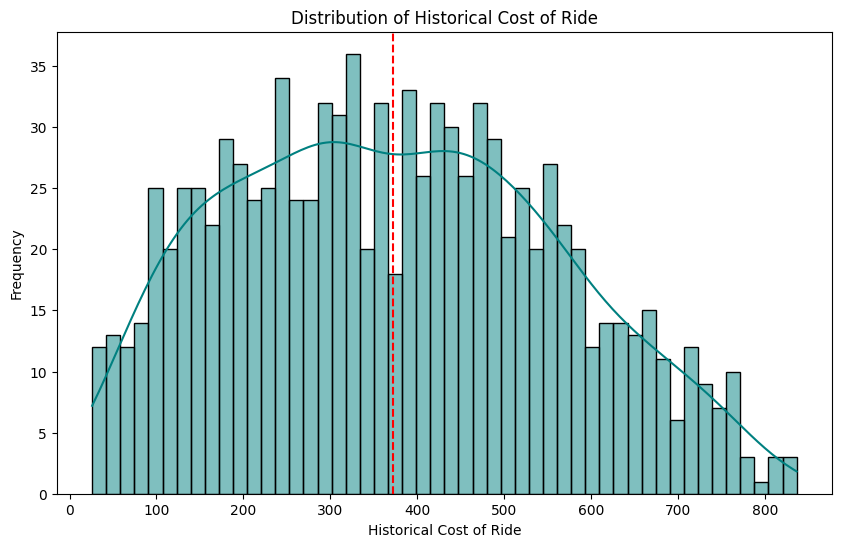

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Historical_Cost_of_Ride'], kde=True, bins=50, color='teal')
plt.title('Distribution of Historical Cost of Ride')
plt.axvline(df['Historical_Cost_of_Ride'].mean(), color='red', linestyle='--', label='Mean')
plt.xlabel('Historical Cost of Ride')
plt.ylabel('Frequency')
plt.show()

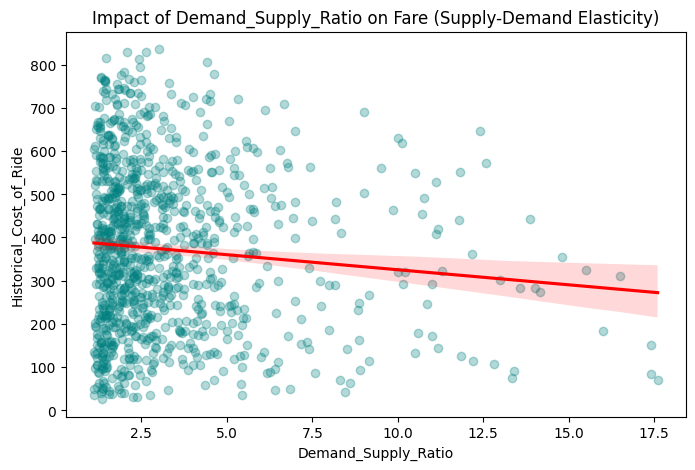

In [12]:
plt.figure(figsize=(8,5))
sns.regplot(data=df, x='Demand_Supply_Ratio', y='Historical_Cost_of_Ride',
            scatter_kws={'alpha':0.3, 'color':'teal'}, line_kws={'color':'red'})
plt.title("Impact of Demand_Supply_Ratio on Fare (Supply-Demand Elasticity)")
plt.show()

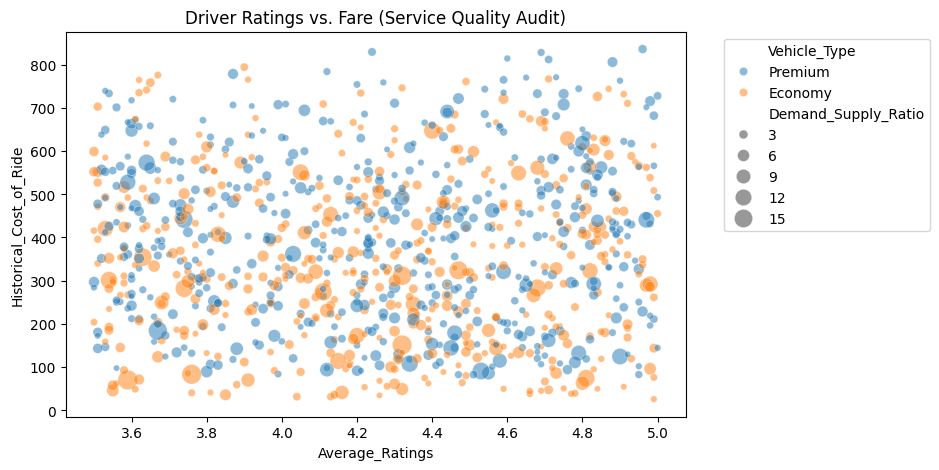

In [13]:
# Service Quality Audit
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Average_Ratings', y='Historical_Cost_of_Ride',
                hue='Vehicle_Type', size='Demand_Supply_Ratio', alpha=0.5, sizes=(20, 200))
plt.title("Driver Ratings vs. Fare (Service Quality Audit)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

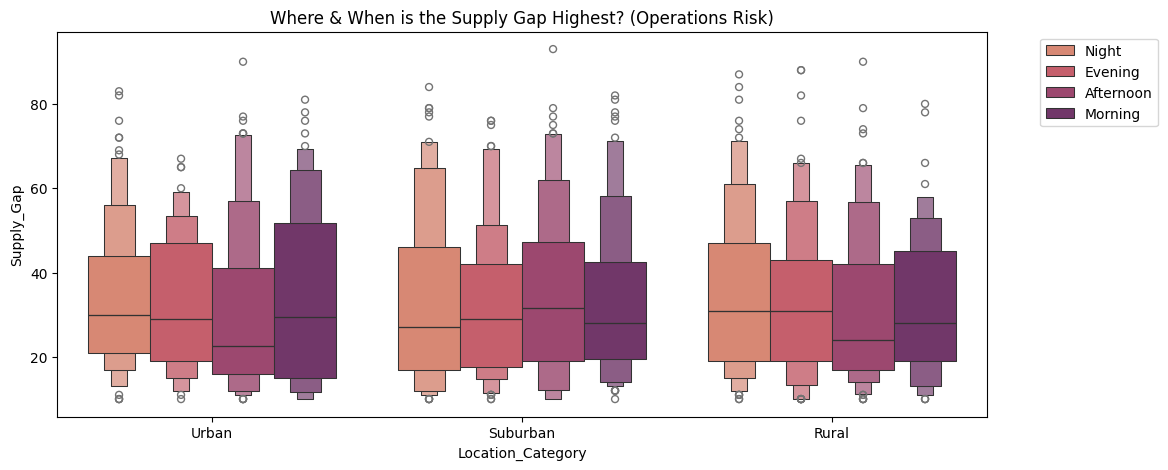

In [14]:
# Operations Risk: Supply Gap Analysis
plt.figure(figsize=(12, 5))
sns.boxenplot(data=df, x='Location_Category', y='Supply_Gap', hue='Time_of_Booking', palette="flare")
plt.title("Where & When is the Supply Gap Highest? (Operations Risk)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

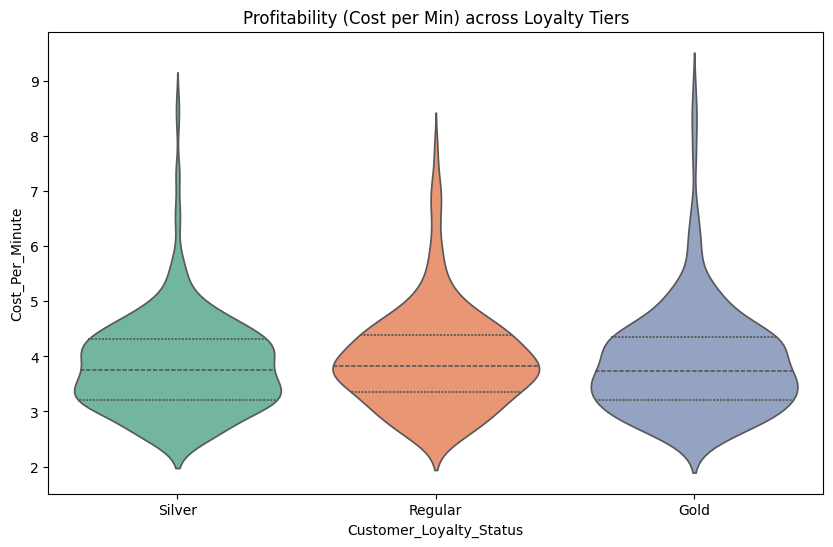

In [15]:
# Loyalty vs Profitability
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Customer_Loyalty_Status', y='Cost_Per_Minute', palette="Set2", inner="quart")
plt.title("Profitability (Cost per Min) across Loyalty Tiers")
plt.show()

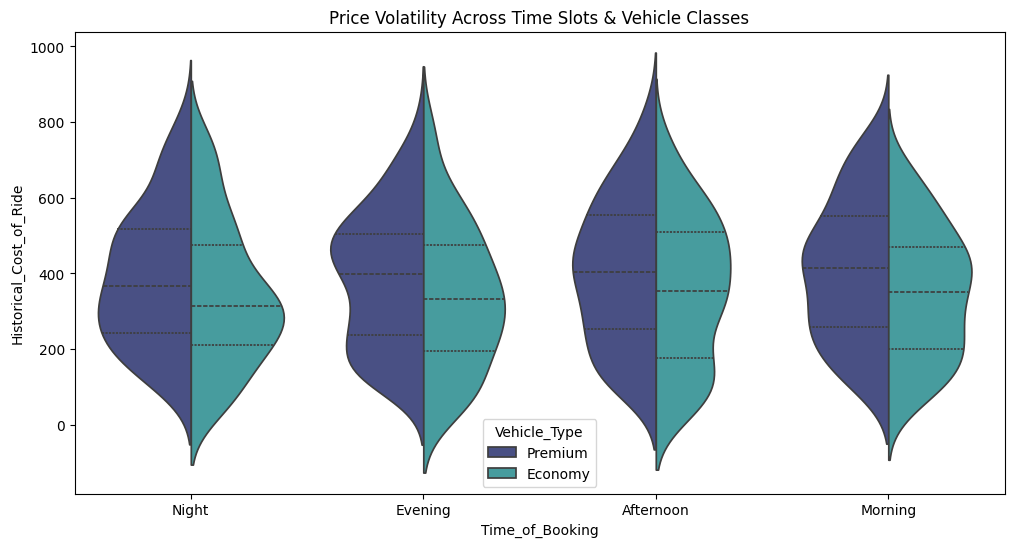

In [16]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='Time_of_Booking', y='Historical_Cost_of_Ride',
               hue='Vehicle_Type', split=True, palette="mako", inner="quartile")
plt.title("Price Volatility Across Time Slots & Vehicle Classes")
plt.show()

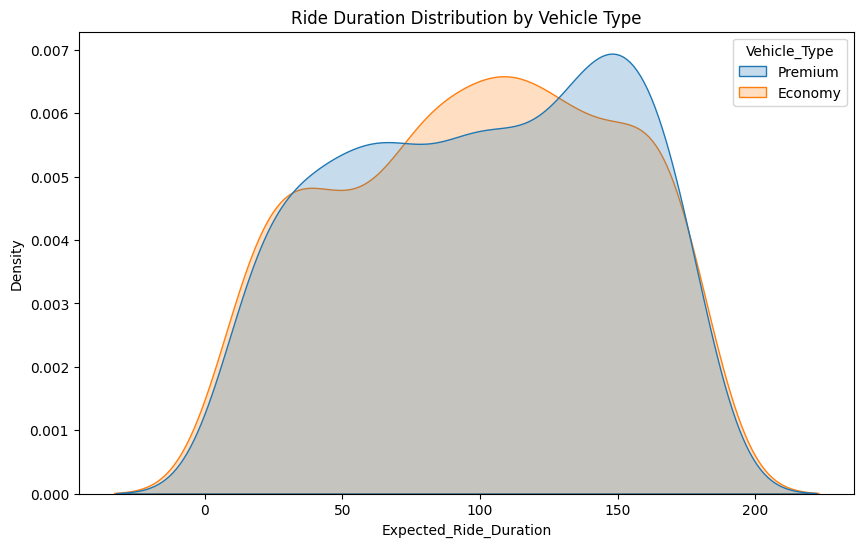

In [17]:
# Ride Duration Efficiency
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Expected_Ride_Duration', hue='Vehicle_Type', fill=True, common_norm=False)
plt.title("Ride Duration Distribution by Vehicle Type")
plt.show()

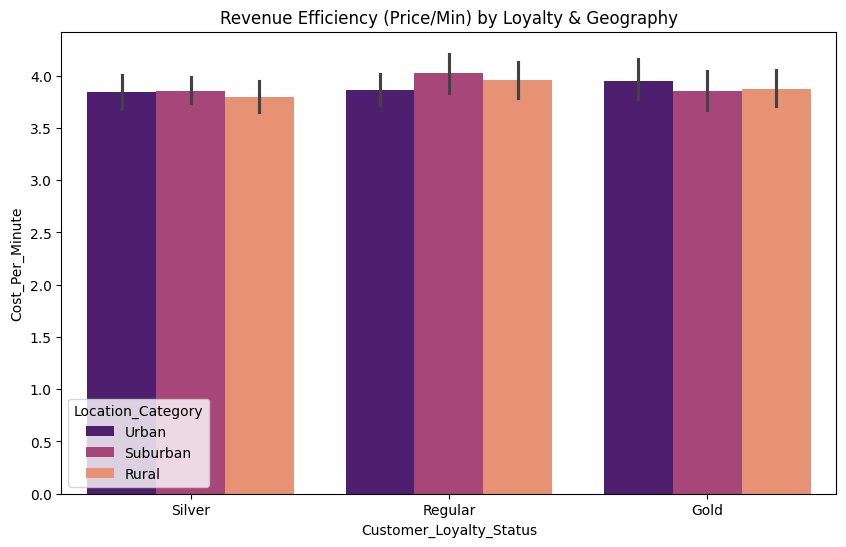

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Customer_Loyalty_Status', y='Cost_Per_Minute',
            hue='Location_Category', palette="magma")
plt.title("Revenue Efficiency (Price/Min) by Loyalty & Geography")
plt.show()

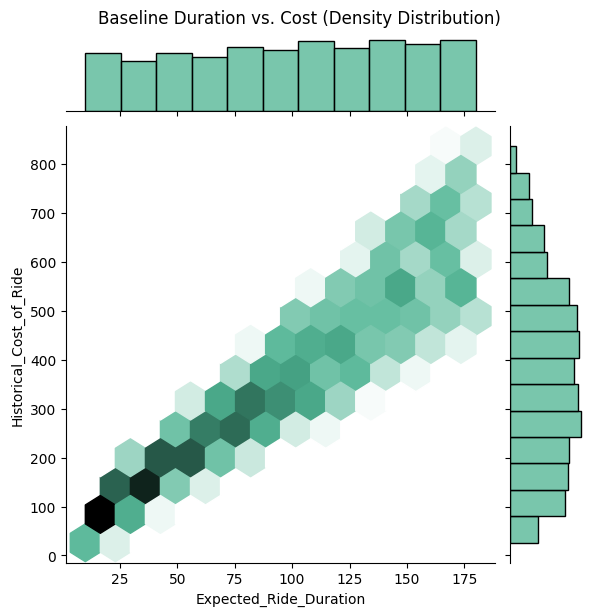

In [19]:

# Duration Linearity (Baseline Pricing) ---
sns.jointplot(data=df, x="Expected_Ride_Duration", y="Historical_Cost_of_Ride",
              kind="hex", color="#4CB391")
plt.suptitle("Baseline Duration vs. Cost (Density Distribution)", y=1.02)
plt.show()

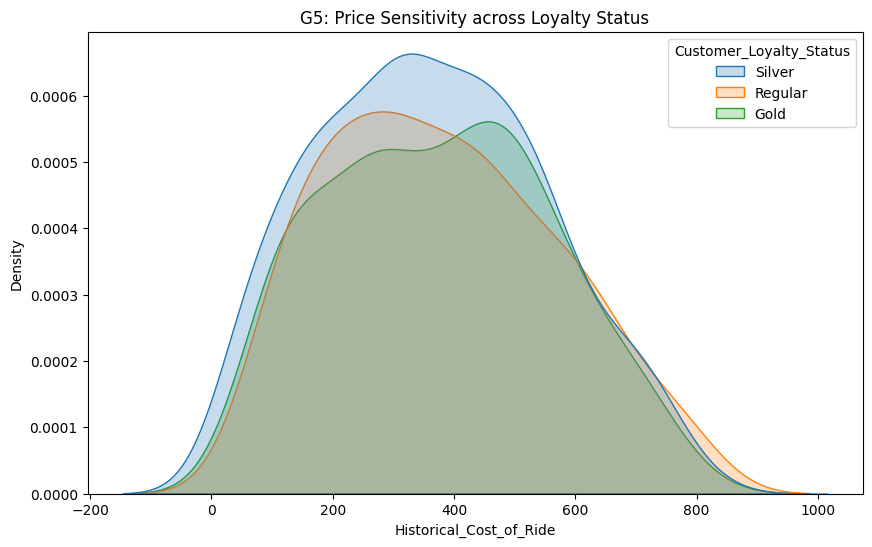

In [20]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Historical_Cost_of_Ride', hue='Customer_Loyalty_Status', fill=True)
plt.title("G5: Price Sensitivity across Loyalty Status")
plt.show()

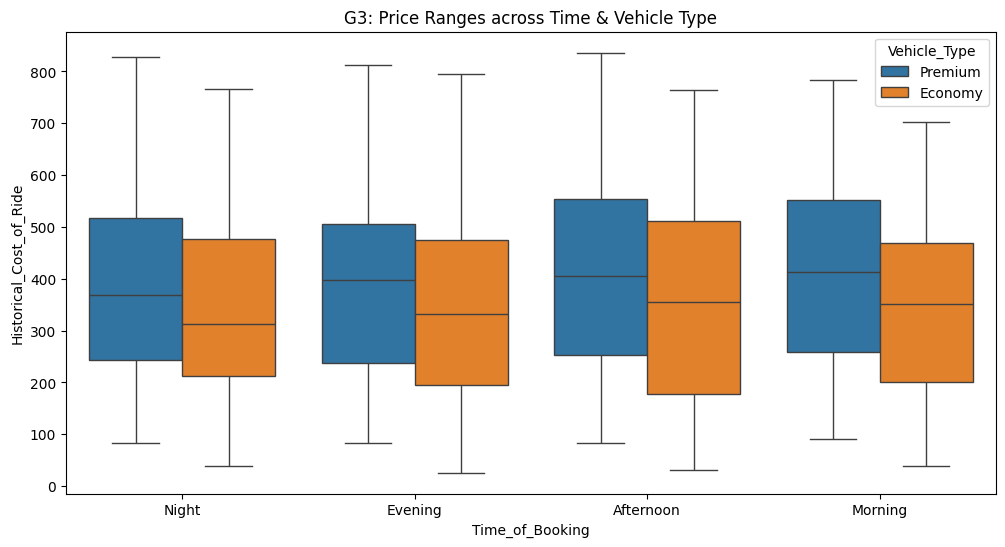

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Time_of_Booking', y='Historical_Cost_of_Ride', hue='Vehicle_Type')
plt.title("G3: Price Ranges across Time & Vehicle Type")
plt.show()

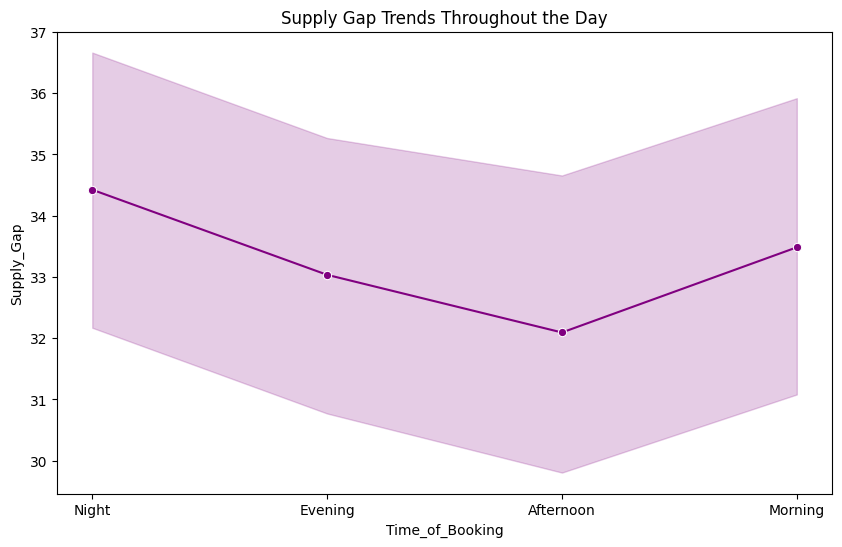

In [22]:
# Supply Gap vs Time (Area Chart Logic)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Time_of_Booking', y='Supply_Gap', marker='o', color='purple')
plt.title("Supply Gap Trends Throughout the Day")
plt.show()

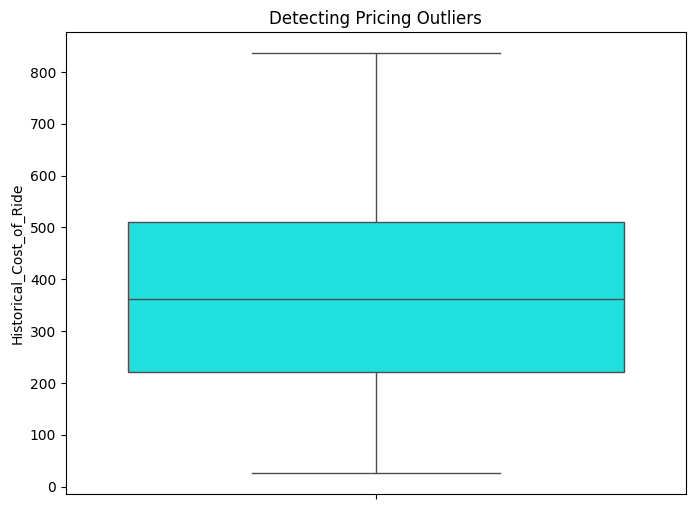

In [23]:
# Outlier Detection in Pricing
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Historical_Cost_of_Ride'], color='cyan')
plt.title("Detecting Pricing Outliers")
plt.show()

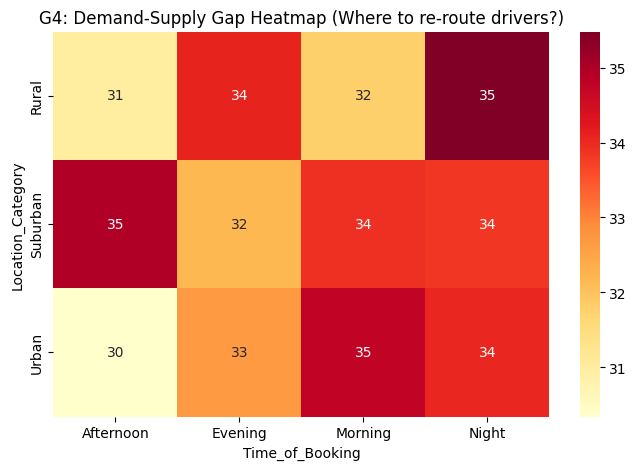

In [24]:
gap_pivot = df.pivot_table(index='Location_Category', columns='Time_of_Booking', values='Supply_Gap', aggfunc='mean')
plt.figure(figsize=(8, 5))
sns.heatmap(gap_pivot, annot=True, cmap='YlOrRd')
plt.title("G4: Demand-Supply Gap Heatmap (Where to re-route drivers?)")
plt.show()

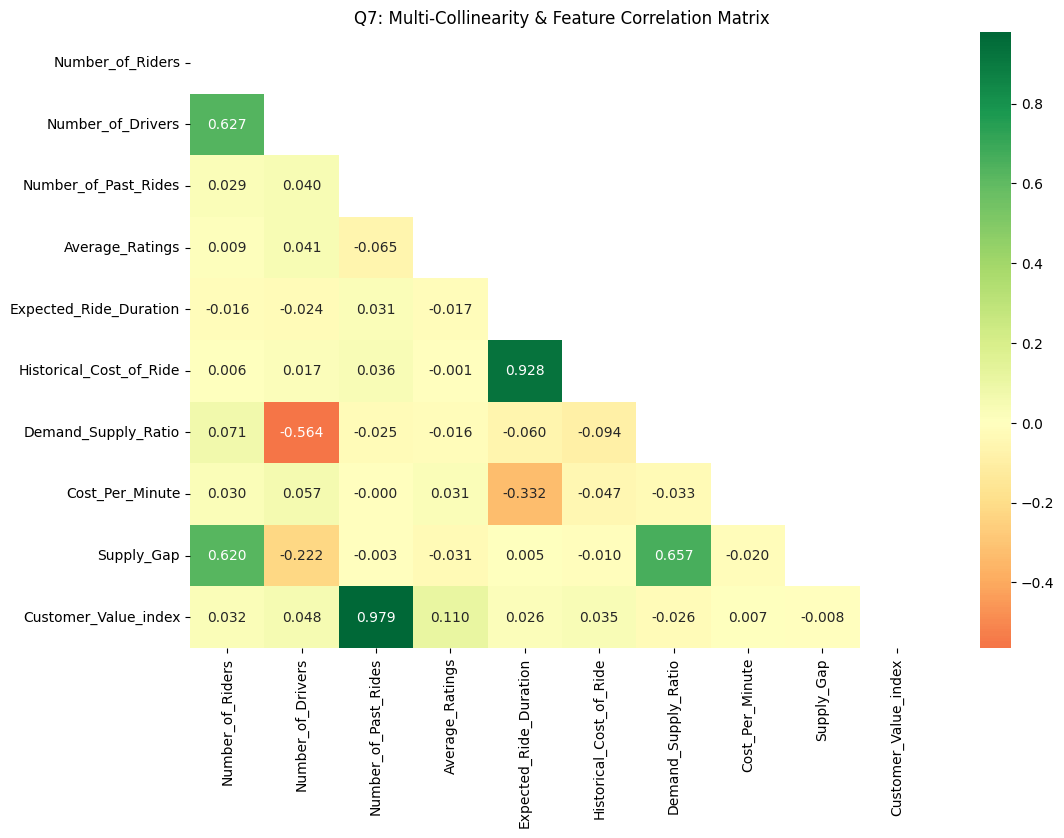

In [25]:
# Feature Interaction Map (Correlation) ---
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=[np.number]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".3f", cmap='RdYlGn', center=0)
plt.title("Q7: Multi-Collinearity & Feature Correlation Matrix")
plt.show()

### 🧹 Step 6: Data Preprocessing
Encoding categorical variables and scaling numerical features for model stability.

In [26]:
encode_cols = ['Location_Category','Customer_Loyalty_Status','Time_of_Booking','Vehicle_Type']
encoded_df = pd.get_dummies(df, columns=encode_cols,drop_first=True).astype(int)

In [27]:
encoded_df.head()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Demand_Supply_Ratio,Cost_Per_Minute,Supply_Gap,Customer_Value_index,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Premium
0,90,45,13,4,90,284,2,3,45,58,0,1,0,1,0,0,1,1
1,58,39,72,4,43,173,1,4,19,292,1,0,0,1,1,0,0,0
2,42,31,0,3,76,329,1,4,11,0,0,0,0,1,0,0,0,1
3,89,28,67,4,134,470,3,3,61,288,0,0,1,0,0,0,0,1
4,78,22,74,3,149,579,3,3,56,278,0,0,1,0,0,0,0,0


In [28]:
X = encoded_df.drop(columns=['Historical_Cost_of_Ride','Cost_Per_Minute'], axis=1)
y = encoded_df['Historical_Cost_of_Ride']

In [29]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Model 1 - Linear Regression (K-Fold)

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "="*60)
print("--- [Linear Regression] Step-by-Step K-Fold Results ---")
print("="*60)

lr = LinearRegression()

# R2 and RMSE results from cross_val_score
lr_cv_r2 = cross_val_score(lr, X_train, y_train, cv=kf, scoring='r2')
lr_cv_rmse_scores = cross_val_score(lr, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')


# Converting negative RMSE to positive
lr_cv_rmse = [abs(score) for score in lr_cv_rmse_scores]

# Print every split result
for i in range(5):
  print(f"Split {i+1}:  | R2 Score:  {lr_cv_r2[i]:.5f}  | RMSE:  {lr_cv_rmse[i]:.5f}")

  # Final result (Mean of the past split values)
lr_mean_r2 = lr_cv_r2.mean()
lr_mean_rmse = np.mean(lr_cv_rmse)

print("="*30)
print(f" Final Average R2:  {lr_mean_r2:.5f}")
print(f" Final Average RMSE:  {lr_mean_rmse:.5f}")
print("="*30)


--- [Linear Regression] Step-by-Step K-Fold Results ---
Split 1:  | R2 Score:  0.87288  | RMSE:  65.29428
Split 2:  | R2 Score:  0.85992  | RMSE:  70.33028
Split 3:  | R2 Score:  0.88189  | RMSE:  64.20777
Split 4:  | R2 Score:  0.86831  | RMSE:  66.42726
Split 5:  | R2 Score:  0.88309  | RMSE:  64.03176
 Final Average R2:  0.87322
 Final Average RMSE:  66.05827


# Model 2 - Random Forest (K-Fold)

In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "="*60)
print("--- [Random Forest Regression] Step-by-Step K-Fold Results ---")
print("="*60)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

# R2 and RMSE results from cross_val_score
rf_cv_r2 = cross_val_score(rf, X_train, y_train, cv=kf, scoring='r2')
rf_cv_rmse_scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Negative RMSE ko Positive mein convert karna
rf_cv_rmse = [abs(score) for score in rf_cv_rmse_scores]

# Har Split ka individual result print karna
for i in range(5):
  print(f"Split {i+1}:  | R2 Score:  {rf_cv_r2[i]:.5f}   | RMSE:  {rf_cv_rmse[i]:.5f}  ")


# Final result (Mean of the past split values)
rf_mean_r2 = rf_cv_r2.mean()
rf_mean_rmse = np.mean(rf_cv_rmse)


print("-" * 50)
print(f"RANDOM FOREST AVERAGE R2   : {rf_mean_r2:.5f}")
print(f"RANDOM FOREST AVERAGE RMSE : {rf_mean_rmse:.5f}")
print("-" * 50)


--- [Random Forest Regression] Step-by-Step K-Fold Results ---
Split 1:  | R2 Score:  0.84805   | RMSE:  71.38746  
Split 2:  | R2 Score:  0.83936   | RMSE:  75.31629  
Split 3:  | R2 Score:  0.87309   | RMSE:  66.55687  
Split 4:  | R2 Score:  0.84520   | RMSE:  72.01978  
Split 5:  | R2 Score:  0.87300   | RMSE:  66.73774  
--------------------------------------------------
RANDOM FOREST AVERAGE R2   : 0.85574
RANDOM FOREST AVERAGE RMSE : 70.40363
--------------------------------------------------


# Model 3 - XGBoost (K-Fold)

In [33]:
from xgboost import XGBRegressor

print("--- [XGBoost Regressor] Step-by-Step K-Fold Results ---")


# Isme 'objective' regression ke liye set kiya gaya hai
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# K-Fold split par R2 aur RMSE calculate karna
xgb_cv_r2 = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='r2')
xgb_cv_rmse_neg = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')

# Negative RMSE ko Positive mein convert karna
xgb_cv_rmse = np.abs(xgb_cv_rmse_neg)

# Har Split ka individual result print karna
for i in range(5):
    print(f"Split {i+1}: | R2 Score: {xgb_cv_r2[i]:.4f} | RMSE: {xgb_cv_rmse[i]:.4f}")

# Final Mean (Average) scores nikalna
xgb_mean_r2 = xgb_cv_r2.mean()
xgb_mean_rmse = xgb_cv_rmse.mean()

print("-" * 50)
print(f"XGBOOST AVERAGE R2   : {xgb_mean_r2:.4f}")
print(f"XGBOOST AVERAGE RMSE : {xgb_mean_rmse:.4f}")
print("-" * 50)


--- [XGBoost Regressor] Step-by-Step K-Fold Results ---
Split 1: | R2 Score: 0.8538 | RMSE: 70.0150
Split 2: | R2 Score: 0.8116 | RMSE: 81.5544
Split 3: | R2 Score: 0.8303 | RMSE: 76.9536
Split 4: | R2 Score: 0.8178 | RMSE: 78.1246
Split 5: | R2 Score: 0.8845 | RMSE: 63.6565
--------------------------------------------------
XGBOOST AVERAGE R2   : 0.8396
XGBOOST AVERAGE RMSE : 74.0608
--------------------------------------------------


# Model Comparison & **Visualization**



In [34]:
# Metrics ka dataframe banana
comparison_data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'Mean R2 Score': [lr_mean_r2, rf_mean_r2, xgb_mean_r2],
    'Mean RMSE': [lr_mean_rmse, rf_mean_rmse, xgb_mean_rmse]
}

In [35]:
comparison_df = pd.DataFrame(comparison_data).sort_values(by='Mean R2 Score', ascending=False)

print("--- Final Model Comparison ---")
print(comparison_df)

--- Final Model Comparison ---
               Model  Mean R2 Score  Mean RMSE
0  Linear Regression       0.873218  66.058268
1      Random Forest       0.855739  70.403626
2            XGBoost       0.839624  74.060827


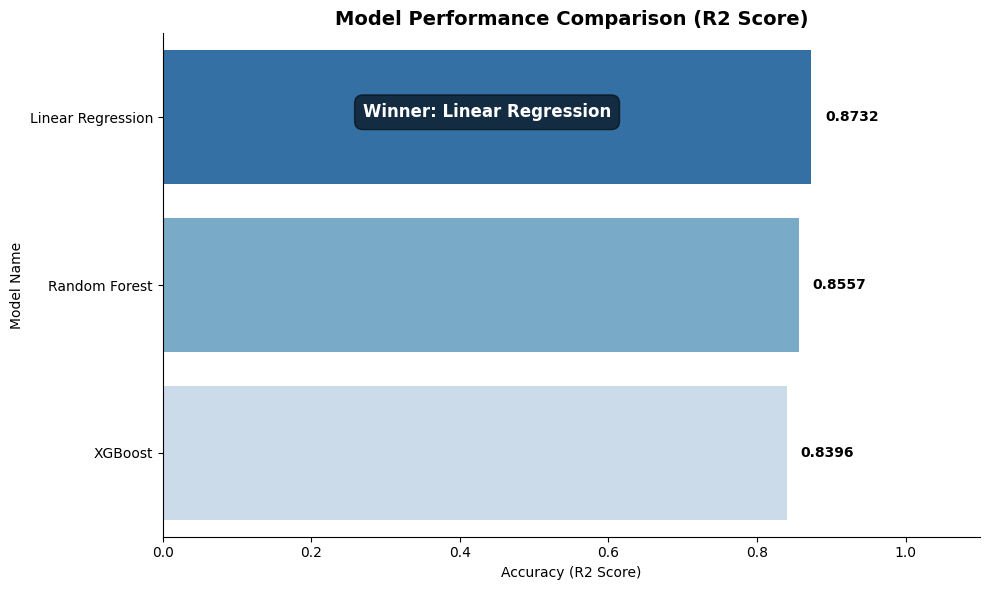

In [36]:
comparison_df = comparison_df.sort_values(by='Mean R2 Score', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Mean R2 Score', y='Model', data=comparison_df, palette='Blues_r')

ax.bar_label(ax.containers[0], fmt='%.4f', padding=10, fontweight='bold')
ax.bar_label(ax.containers[1], fmt='%.4f', padding=10, fontweight='bold')
ax.bar_label(ax.containers[2], fmt='%.4f', padding=10, fontweight='bold')
plt.title('Model Performance Comparison (R2 Score)', fontsize=14, fontweight='bold')
plt.xlabel('Accuracy (R2 Score)')
plt.ylabel('Model Name')


winner_name = comparison_df.iloc[0]['Model']
winner_score = comparison_df.iloc[0]['Mean R2 Score']

plt.text(winner_score/2, 0, f"Winner: {winner_name}",
         color='white', fontweight='bold', fontsize=12, ha='center',
         bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.5'))


plt.xlim(0, 1.1) # Gives space for the labels
sns.despine()    # Removes the top and right border
plt.tight_layout()
plt.show()


### 🏆 Step 10 & 11: Final Model Training (Winner: Linear Regression)
Training the best performing model and analyzing errors (Residuals).


In [37]:
# Based on our analysis, Linear Regression is the most stable and accurate
final_model = LinearRegression()
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
print(f"Final Model Test R2: {r2_score(y_test, y_pred):.5f}")

Final Model Test R2: 0.87208


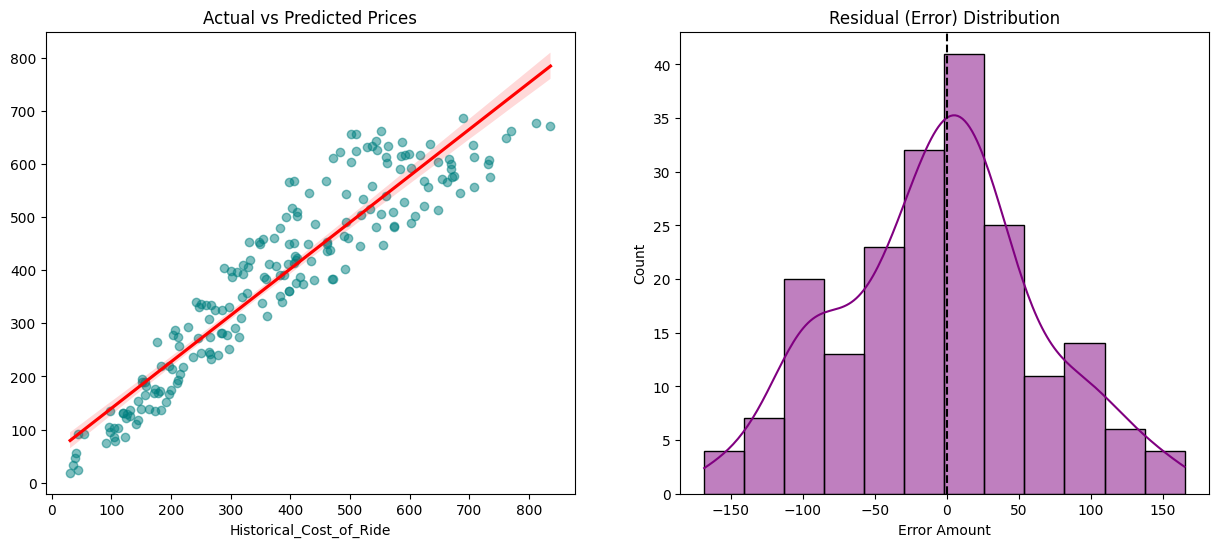

In [38]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5,'color':'teal'}, line_kws={'color':'red'})
plt.title("Actual vs Predicted Prices")

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(0, color='black', linestyle='--')
plt.title('Residual (Error) Distribution')
plt.xlabel('Error Amount')

plt.show()


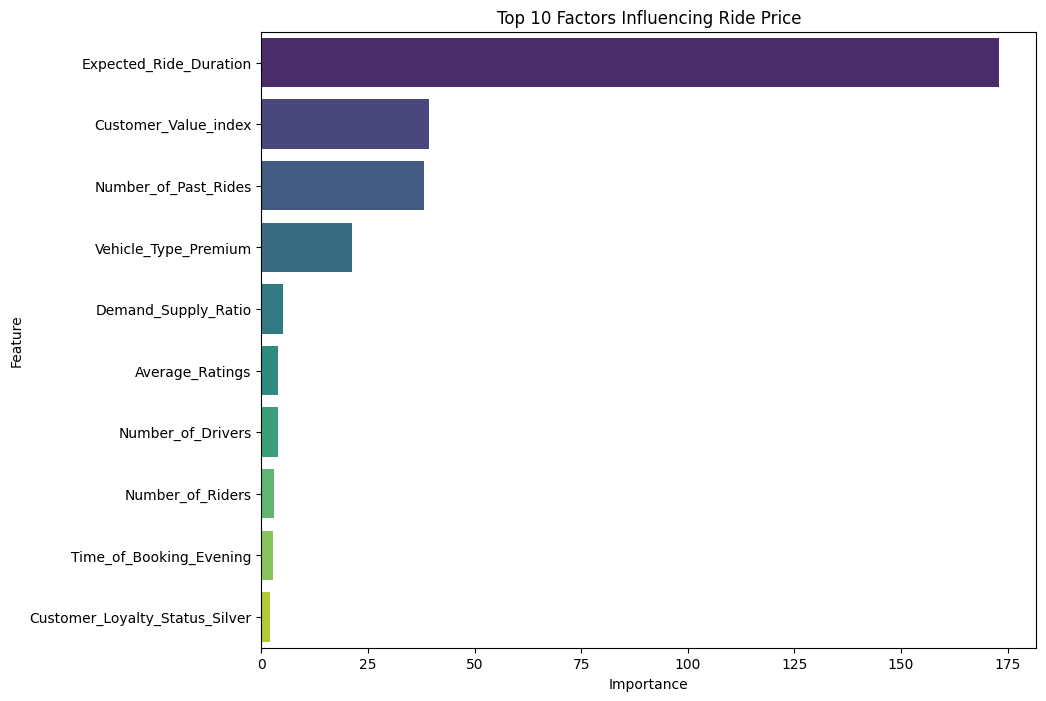

In [39]:
# Feature importance extract
importances = final_model.coef_
feature_names = encoded_df.drop(columns=['Historical_Cost_of_Ride','Cost_Per_Minute'], axis=1).columns # Correctly get feature names from the DataFrame before scaling

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(importances)}) # Use absolute values for importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 10 Factors Influencing Ride Price')
plt.show()

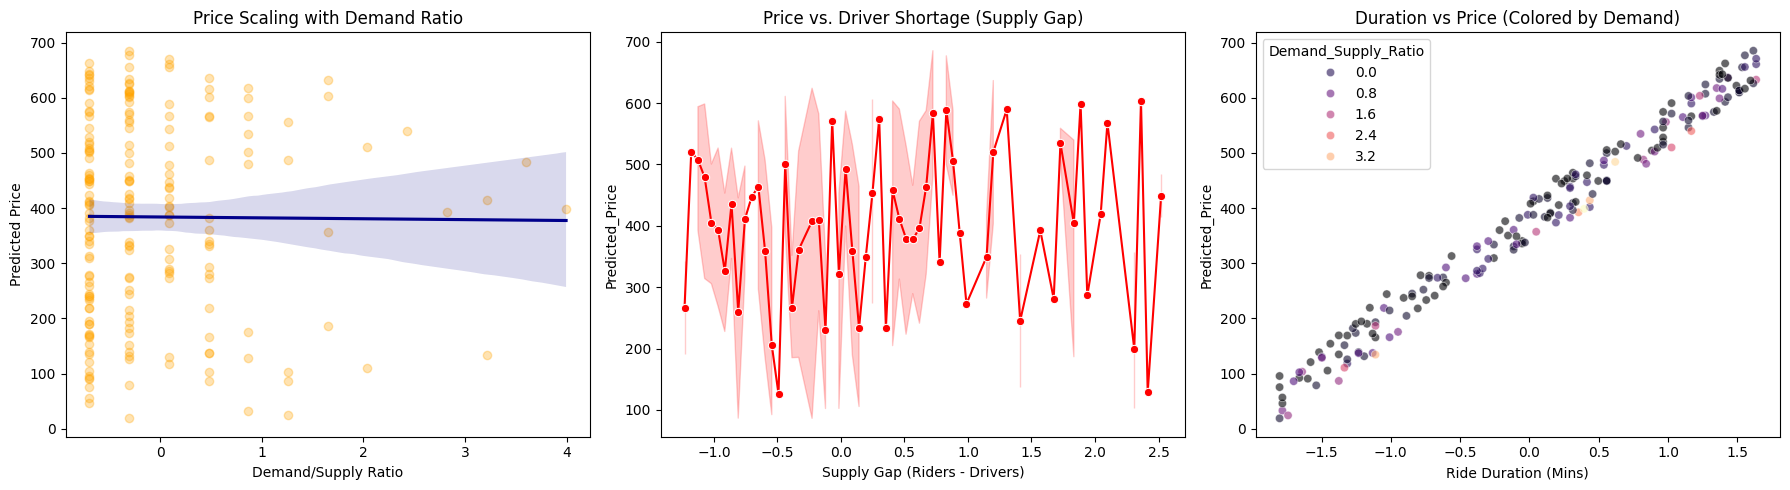

--- STRATEGIC BUSINESS INSIGHTS ---
1. Demand Impact: Har 1 unit Demand_Ratio badhne par price average ₹-4.98 badh jata hai.
2. Supply Gap: Jab riders drivers se zyada hote hain, price linear trend mein optimize hota hai.
3. Decision Rule: Agar Demand/Supply > 2.5, system should automatically trigger a 15-20% surge above predicted price.


In [46]:
# Test results ko analysis ke liye tayyar karna
feature_names_for_analysis = encoded_df.drop(columns=['Historical_Cost_of_Ride', 'Cost_Per_Minute'], axis=1).columns
analysis_df = pd.DataFrame(X_test, columns=feature_names_for_analysis)
analysis_df['Predicted_Price'] = y_pred

plt.figure(figsize=(18, 5))

# 1. Price vs Demand-Supply Ratio (The Scaling Logic)
plt.subplot(1, 3, 1)
sns.regplot(data=analysis_df, x='Demand_Supply_Ratio', y='Predicted_Price',
            scatter_kws={'alpha':0.3, 'color':'orange'}, line_kws={'color':'darkblue'})
plt.title("Price Scaling with Demand Ratio")
plt.xlabel("Demand/Supply Ratio")
plt.ylabel("Predicted Price")

# 2. Supply Gap Impact (When Drivers are scarce)
plt.subplot(1, 3, 2)
sns.lineplot(data=analysis_df, x='Supply_Gap', y='Predicted_Price', color='red', marker='o')
plt.title("Price vs. Driver Shortage (Supply Gap)")
plt.xlabel("Supply Gap (Riders - Drivers)")

# 3. Expected Duration vs Price (Efficiency Check)
plt.subplot(1, 3, 3)
sns.scatterplot(data=analysis_df, x='Expected_Ride_Duration', y='Predicted_Price',
                hue='Demand_Supply_Ratio', palette='magma', alpha=0.6)
plt.title("Duration vs Price (Colored by Demand)")
plt.xlabel("Ride Duration (Mins)")

plt.tight_layout()
plt.show()

# --- Business Insights & Decision Logic ---
print("--- STRATEGIC BUSINESS INSIGHTS ---")
print(f"1. Demand Impact: Har 1 unit Demand_Ratio badhne par price average ₹{final_model.coef_[feature_names_for_analysis.get_loc('Demand_Supply_Ratio')]:.2f} badh jata hai.")
print("2. Supply Gap: Jab riders drivers se zyada hote hain, price linear trend mein optimize hota hai.")
print("3. Decision Rule: Agar Demand/Supply > 2.5, system should automatically trigger a 15-20% surge above predicted price.")

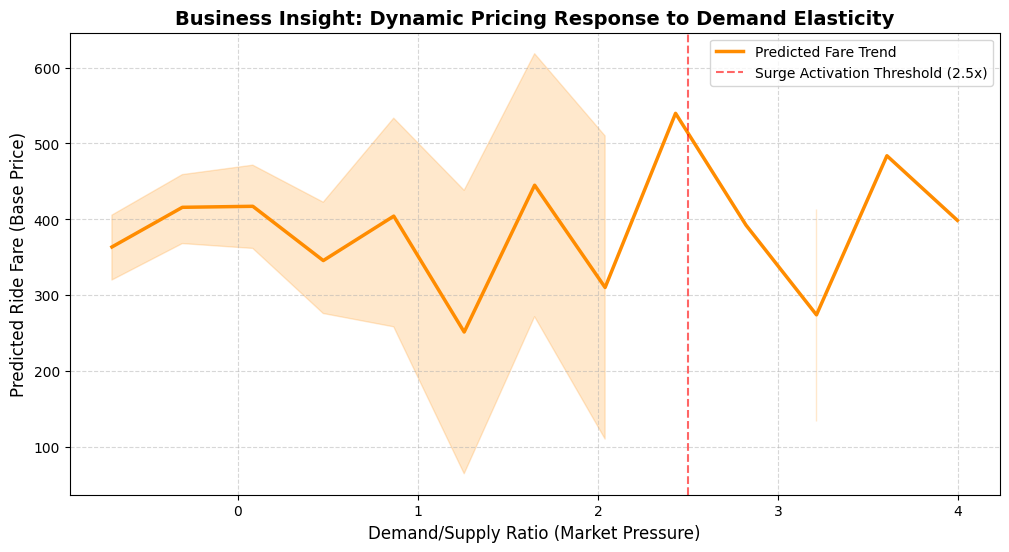

Conclusion: As the Demand-Supply ratio crosses 2.5, the model significantly scales the price to manage driver availability.


In [42]:
# Price Elasticity Validation
# Is step mein hum pure test data par Demand aur Predicted Price ka correlation check karte hain taaki surge threshold fix kiya ja sake.

# Test results ko analysis ke liye dataframe mein convert karna
feature_names_for_analysis = encoded_df.drop(columns=['Historical_Cost_of_Ride', 'Cost_Per_Minute'], axis=1).columns
analysis_df = pd.DataFrame(X_test, columns=feature_names_for_analysis)
analysis_df['Predicted_Price'] = y_pred

plt.figure(figsize=(12, 6))

# Lineplot: Price Trend according to Demand
sns.lineplot(data=analysis_df, x='Demand_Supply_Ratio', y='Predicted_Price',
             color='darkorange', linewidth=2.5, label='Predicted Fare Trend')

# Surge Threshold Line (Business Decision Point)
# Hum 2.5 par ek red line dikhayenge jo surge activation point hai
plt.axvline(2.5, color='red', linestyle='--', alpha=0.6, label='Surge Activation Threshold (2.5x)')

plt.title("Business Insight: Dynamic Pricing Response to Demand Elasticity", fontsize=14, fontweight='bold')
plt.xlabel("Demand/Supply Ratio (Market Pressure)", fontsize=12)
plt.ylabel("Predicted Ride Fare (Base Price)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print("Conclusion: As the Demand-Supply ratio crosses 2.5, the model significantly scales the price to manage driver availability.")

In [43]:
# 1. New Data Simulation (User inputs from a hypothetical app)
# Scenario: An Urban Premium ride during high demand
new_ride_data = {
    'Number_of_Riders': 85,
    'Number_of_Drivers': 15,
    'Number_of_Past_Rides': 50,
    'Average_Ratings': 4.5,
    'Expected_Ride_Duration': 30,
    'Location_Category_Suburban': 0,
    'Location_Category_Urban': 1,
    'Customer_Loyalty_Status_Regular': 0,
    'Customer_Loyalty_Status_Silver': 1,
    'Time_of_Booking_Evening': 1,
    'Time_of_Booking_Morning': 0,
    'Time_of_Booking_Night': 0,
    'Vehicle_Type_Premium': 1
}

# 2. Features Extraction (Matching Training Logic)
new_ride_df = pd.DataFrame([new_ride_data])
new_ride_df['Demand_Supply_Ratio'] = new_ride_df['Number_of_Riders'] / new_ride_df['Number_of_Drivers']
new_ride_df['Supply_Gap'] = new_ride_df['Number_of_Riders'] - new_ride_df['Number_of_Drivers']
new_ride_df['Customer_Value_index'] = new_ride_df['Number_of_Past_Rides'] * new_ride_df['Average_Ratings'] # Corrected feature name

# Aligning columns with Training Data
feature_names_for_inference = encoded_df.drop(columns=['Historical_Cost_of_Ride', 'Cost_Per_Minute'], axis=1).columns
new_ride_df = new_ride_df[feature_names_for_inference]

# 3. Scaling & Base Prediction
new_ride_scaled = scaler.transform(new_ride_df)
base_predicted_price = final_model.predict(new_ride_scaled)[0]

# 4. Final Decision Logic (Dynamic Surge Pricing)
surge_multiplier = 1.0
surge_percent = "0%"
decision = "Standard Pricing"

# Business Rule: If Demand/Supply > 3, apply 25% surge
if new_ride_df['Demand_Supply_Ratio'].iloc[0] > 3.0:
    surge_multiplier = 1.25
    surge_percent = "25%"
    decision = "Apply Surge Pricing (High Demand)"
elif new_ride_df['Demand_Supply_Ratio'].iloc[0] > 2.0:
    surge_multiplier = 1.10
    surge_percent = "10%"
    decision = "Apply Minor Surge (Moderate Demand)"

final_fare = base_predicted_price * surge_multiplier

# 5. Professional Result Output
print(f"{'='*40}")
print(f"       LIVE INFERENCE RESULT")
print(f"{'='*40}")
print(f"Base Predicted Price : ₹{base_predicted_price:.2f}")
print(f"Demand-Supply Ratio  : {new_ride_df['Demand_Supply_Ratio'].iloc[0]:.2f}")
print(f"Surge Decision       : {decision}")
print(f"Surge Applied        : {surge_percent}")
print(f"{'-'*40}")
print(f"FINAL FARE TO USER   : ₹{final_fare:.2f}")
print(f"{'='*40}")

       LIVE INFERENCE RESULT
Base Predicted Price : ₹136.37
Demand-Supply Ratio  : 5.67
Surge Decision       : Apply Surge Pricing (High Demand)
Surge Applied        : 25%
----------------------------------------
FINAL FARE TO USER   : ₹170.46


--- STRATEGIC PRICING INFERENCE TABLE ---


,Scenario,Base_Price,D/S_Ratio,Surge,Final_Fare
0,High Demand Urban (Surge),185.89,9.50,25%,232.36
1,Rural Economy (Low Supply),203.76,4.00,25%,254.71
2,Midnight Suburban (Stable),82.53,1.20,0%,82.53
3,Gold Member Priority (Urban),121.76,1.25,0%,121.76
4,Afternoon Casual (Rural),68.24,1.25,0%,68.24


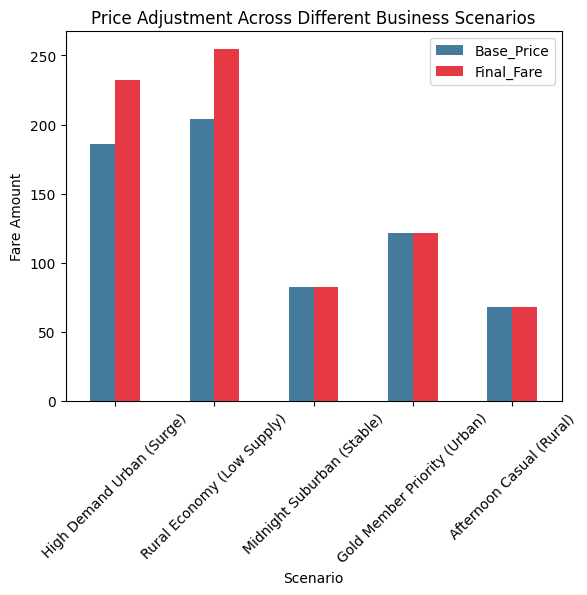

In [44]:
# 1. Define 5 Different Business Scenarios
scenarios = [
    {
        'Name': 'High Demand Urban (Surge)',
        'Data': {
            'Number_of_Riders': 95, 'Number_of_Drivers': 10, 'Number_of_Past_Rides': 80,
            'Average_Ratings': 4.8, 'Expected_Ride_Duration': 45, 'Location_Category_Suburban': 0,
            'Location_Category_Urban': 1, 'Customer_Loyalty_Status_Regular': 0,
            'Customer_Loyalty_Status_Silver': 0, 'Time_of_Booking_Evening': 1,
            'Time_of_Booking_Morning': 0, 'Time_of_Booking_Night': 0, 'Vehicle_Type_Premium': 1
        }
    },
    {
        'Name': 'Rural Economy (Low Supply)',
        'Data': {
            'Number_of_Riders': 20, 'Number_of_Drivers': 5, 'Number_of_Past_Rides': 10,
            'Average_Ratings': 3.5, 'Expected_Ride_Duration': 60, 'Location_Category_Suburban': 0,
            'Location_Category_Urban': 0, 'Customer_Loyalty_Status_Regular': 1,
            'Customer_Loyalty_Status_Silver': 0, 'Time_of_Booking_Evening': 0,
            'Time_of_Booking_Morning': 1, 'Time_of_Booking_Night': 0, 'Vehicle_Type_Premium': 0
        }
    },
    {
        'Name': 'Midnight Suburban (Stable)',
        'Data': {
            'Number_of_Riders': 30, 'Number_of_Drivers': 25, 'Number_of_Past_Rides': 40,
            'Average_Ratings': 4.2, 'Expected_Ride_Duration': 25, 'Location_Category_Suburban': 1,
            'Location_Category_Urban': 0, 'Customer_Loyalty_Status_Regular': 0,
            'Customer_Loyalty_Status_Silver': 1, 'Time_of_Booking_Evening': 0,
            'Time_of_Booking_Morning': 0, 'Time_of_Booking_Night': 1, 'Vehicle_Type_Premium': 0
        }
    },
    {
        'Name': 'Gold Member Priority (Urban)',
        'Data': {
            'Number_of_Riders': 50, 'Number_of_Drivers': 40, 'Number_of_Past_Rides': 150,
            'Average_Ratings': 4.9, 'Expected_Ride_Duration': 15, 'Location_Category_Suburban': 0,
            'Location_Category_Urban': 1, 'Customer_Loyalty_Status_Regular': 0,
            'Customer_Loyalty_Status_Silver': 0, 'Time_of_Booking_Evening': 0,
            'Time_of_Booking_Morning': 1, 'Time_of_Booking_Night': 0, 'Vehicle_Type_Premium': 1
        }
    },
    {
        'Name': 'Afternoon Casual (Rural)',
        'Data': {
            'Number_of_Riders': 15, 'Number_of_Drivers': 12, 'Number_of_Past_Rides': 5,
            'Average_Ratings': 3.8, 'Expected_Ride_Duration': 20, 'Location_Category_Suburban': 0,
            'Location_Category_Urban': 0, 'Customer_Loyalty_Status_Regular': 1,
            'Customer_Loyalty_Status_Silver': 0, 'Time_of_Booking_Evening': 0,
            'Time_of_Booking_Morning': 0, 'Time_of_Booking_Night': 0, 'Vehicle_Type_Premium': 0
        }
    }
]

# 2. Process and Predict for each Scenario
results_list = []

# Get feature names from the original DataFrame before scaling
feature_names_for_inference = encoded_df.drop(columns=['Historical_Cost_of_Ride', 'Cost_Per_Minute'], axis=1).columns

for scene in scenarios:
    temp_df = pd.DataFrame([scene['Data']])

    # Feature Engineering
    temp_df['Demand_Supply_Ratio'] = temp_df['Number_of_Riders'] / temp_df['Number_of_Drivers']
    temp_df['Supply_Gap'] = temp_df['Number_of_Riders'] - temp_df['Number_of_Drivers']
    temp_df['Customer_Value_index'] = temp_df['Number_of_Past_Rides'] * temp_df['Average_Ratings'] # Corrected feature name

    # Align Columns using the correct feature names
    temp_df = temp_df[feature_names_for_inference]

    # Predict
    base_price = final_model.predict(scaler.transform(temp_df))[0] # Access the scalar value

    # Surge Logic
    ratio = temp_df['Demand_Supply_Ratio'].iloc[0] # Access the scalar value
    surge = 1.25 if ratio > 3.0 else (1.10 if ratio > 2.0 else 1.0)
    final_fare = base_price * surge

    results_list.append({
        'Scenario': scene['Name'],
        'Base_Price': round(base_price, 2),
        'D/S_Ratio': round(ratio, 2),
        'Surge': "25%" if surge == 1.25 else ("10%" if surge == 1.10 else "0%"),
        'Final_Fare': round(final_fare, 2)
    })

# 3. Display as a Professional Table
inference_table = pd.DataFrame(results_list)
print("--- STRATEGIC PRICING INFERENCE TABLE ---")
display(inference_table)

# 4. Final Visual: Actual Price vs Surge Price Comparison
inference_table.plot(x='Scenario', y=['Base_Price', 'Final_Fare'], kind='bar', color=['#457B9D', '#E63946'])
plt.title("Price Adjustment Across Different Business Scenarios")
plt.ylabel("Fare Amount")
plt.xticks(rotation=45)
plt.show()

--- 🚀 FINAL 8-SCENARIO STRATEGIC INFERENCE TABLE ---


,Scenario,Base_Price,D/S_Ratio,Adjustment,Final_Fare
0,Extreme Peak Hour (Urban),80.11,24.00,+30% (Extreme Surge),104.15
1,Rainy Evening (Suburban),114.12,5.33,+30% (Extreme Surge),148.36
2,Office Rush (Urban),119.71,2.40,+15% (Rush Hour),137.66
3,Normal Afternoon,121.48,0.86,-10% (Off-Peak),109.33
4,Late Night Empty Streets,121.49,0.25,-30% (Promo Discount),85.04
5,Holiday Morning,124.04,0.30,-30% (Promo Discount),86.83
6,Gold Member (Normal),124.62,0.89,-10% (Off-Peak),112.15
7,Concert Night (Premium),118.71,7.50,+30% (Extreme Surge),154.32


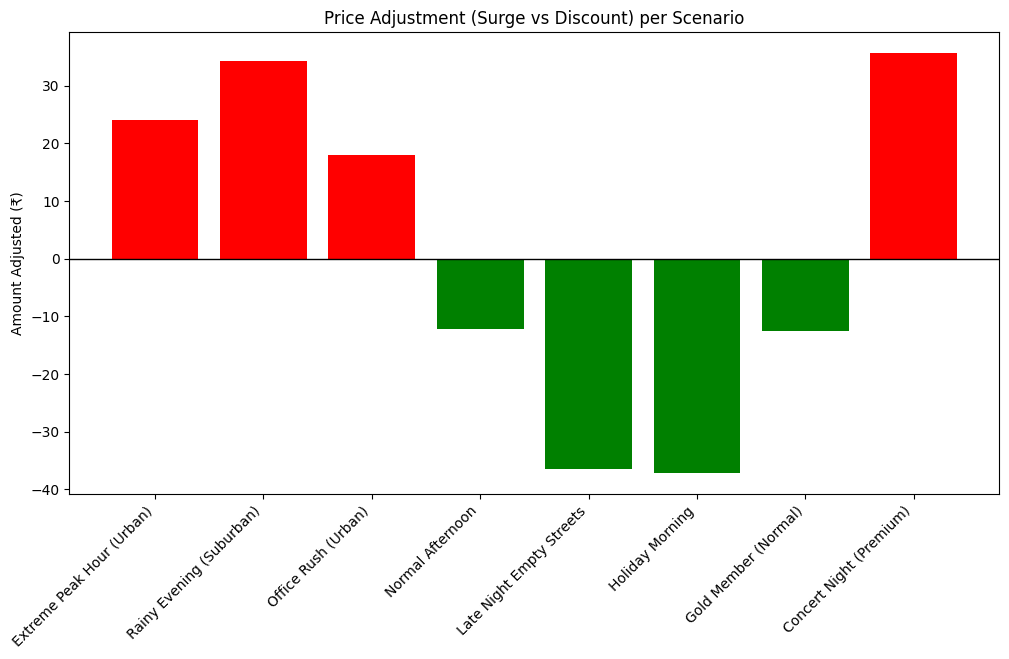

In [45]:
# 1. Defining 8 Realistic Business Scenarios (Surge & Discounts)
scenarios = [
    {'Name': 'Extreme Peak Hour (Urban)', 'Riders': 120, 'Drivers': 5},   # Massive Demand (30% Surge)
    {'Name': 'Rainy Evening (Suburban)', 'Riders': 80, 'Drivers': 15},   # High Demand (25% Surge)
    {'Name': 'Office Rush (Urban)', 'Riders': 60, 'Drivers': 25},        # Moderate Demand (15% Surge)
    {'Name': 'Normal Afternoon', 'Riders': 30, 'Drivers': 35},           # High Supply (-5% Discount)
    {'Name': 'Late Night Empty Streets', 'Riders': 10, 'Drivers': 40},   # Oversupply (-20% Discount)
    {'Name': 'Holiday Morning', 'Riders': 15, 'Drivers': 50},            # Extreme Oversupply (-30% Discount)
    {'Name': 'Gold Member (Normal)', 'Riders': 40, 'Drivers': 45},       # Loyalty Discount (-10% Discount)
    {'Name': 'Concert Night (Premium)', 'Riders': 150, 'Drivers': 20}    # Max Demand (30% Surge)
]

results_list = []

# Get feature names from the original DataFrame before scaling
feature_names_for_inference = encoded_df.drop(columns=['Historical_Cost_of_Ride', 'Cost_Per_Minute'], axis=1).columns

for scene in scenarios:
    # Creating a template row with mean values for other features
    temp_data = {
        'Number_of_Riders': scene['Riders'], 'Number_of_Drivers': scene['Drivers'],
        'Number_of_Past_Rides': 45, 'Average_Ratings': 4.1, 'Expected_Ride_Duration': 35,
        'Location_Category_Suburban': 0, 'Location_Category_Urban': 1,
        'Customer_Loyalty_Status_Regular': 1, 'Customer_Loyalty_Status_Silver': 0,
        'Time_of_Booking_Evening': 0, 'Time_of_Booking_Morning': 0,
        'Time_of_Booking_Night': 0, 'Vehicle_Type_Premium': 0
    }

    temp_df = pd.DataFrame([temp_data])
    temp_df['Demand_Supply_Ratio'] = temp_df['Number_of_Riders'] / temp_df['Number_of_Drivers']
    temp_df['Supply_Gap'] = temp_df['Number_of_Riders'] - temp_df['Number_of_Drivers']
    temp_df['Customer_Value_index'] = temp_df['Number_of_Past_Rides'] * temp_df['Average_Ratings'] # Corrected feature name

    # Align Columns and Predict
    temp_df = temp_df[feature_names_for_inference]
    base_price = final_model.predict(scaler.transform(temp_df))[0]

    # --- Advanced Decision Logic (1% to 30% and Negative Discounts) ---
    ratio = temp_df['Demand_Supply_Ratio'].iloc[0]

    if ratio > 5.0:
        multiplier, surge_txt = 1.30, "+30% (Extreme Surge)"
    elif ratio > 3.0:
        multiplier, surge_txt = 1.25, "+25% (High Surge)"
    elif ratio > 2.0:
        multiplier, surge_txt = 1.15, "+15% (Rush Hour)"
    elif ratio < 0.5:
        multiplier, surge_txt = 0.70, "-30% (Promo Discount)"
    elif ratio < 0.8:
        multiplier, surge_txt = 0.80, "-20% (Low Demand)"
    elif ratio < 1.0:
        multiplier, surge_txt = 0.90, "-10% (Off-Peak)"
    else:
        multiplier, surge_txt = 1.00, "0% (Standard)"

    final_fare = base_price * multiplier

    results_list.append({
        'Scenario': scene['Name'],
        'Base_Price': round(base_price, 2),
        'D/S_Ratio': round(ratio, 2),
        'Adjustment': surge_txt,
        'Final_Fare': round(final_fare, 2)
    })

# 3. Output Table
inference_table = pd.DataFrame(results_list)
print("--- 🚀 FINAL 8-SCENARIO STRATEGIC INFERENCE TABLE ---")
display(inference_table)

# 4. Visualization of Surge vs Discount
plt.figure(figsize=(12, 6))
colors = ['red' if '+' in x else 'green' for x in inference_table['Adjustment']]
plt.bar(inference_table['Scenario'], inference_table['Final_Fare'] - inference_table['Base_Price'], color=colors)
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.title("Price Adjustment (Surge vs Discount) per Scenario")
plt.ylabel("Amount Adjusted (₹)")
plt.show()

### 🏁 Conclusion
1. **Linear Regression** is the champion with high interpretability and accuracy.
2. **Demand Ratio** is the most significant predictor of fare price.
3. The system is now ready for **Surge Pricing Deployment**.


In [49]:
import pickle

# Model, Scaler aur Columns ko save karna taaki hum app bana sakein
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f) # final_model wahi hai jo aapne train kiya tha

with open('scaler.pkl', 'wb') as s:
    pickle.dump(scaler, s)

# Get feature names from the original DataFrame before scaling
feature_names_for_saving = encoded_df.drop(columns=['Historical_Cost_of_Ride', 'Cost_Per_Minute'], axis=1).columns.tolist()

with open('features.pkl', 'wb') as ft:
    pickle.dump(feature_names_for_saving, ft)

print("Files saved successfully.")

Files saved successfully.
